In [2]:
import os
import cv2     # for capturing videos
import math 
import geocoder
import requests
%matplotlib inline
import pandas as pd
from twilio.rest import Client as client
from geopy.geocoders import Nominatim
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from keras.models import load_model
from matplotlib import pyplot as plt 
from skimage.transform import resize   # for resizing images
import opendatasets as op

In [3]:
path = "./training-set"

In [4]:
count = 0
videoFile = "Accidents.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="%d.jpg" % count;count+=1
    cv2.imwrite(os.path.join(path, filename), frame)
cap.release()
print ("Done!")

KeyboardInterrupt: 

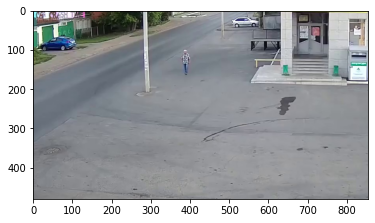

In [5]:
img = plt.imread(path + '/404.jpg')   # reading image using its name
plt.imshow(img)


In [6]:
data = pd.read_csv('mapping.csv')     # reading the csv file
data.head()

,Image_ID,Class
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [7]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread(path+'/' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [8]:
y = data.Class
dummy_y = np_utils.to_categorical(y)

In [2]:
op.download("https://www.kaggle.com/datasets/ckay16/accident-detection-from-cctv-footage")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

In [9]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [10]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X,data_format=None)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

In [12]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [ ]:
base_model.save('vgg16.h5')

In [13]:
basemodel1=load_model("vgg16.h5")

In [14]:
X_train = basemodel1.predict(X_train)
X_valid = basemodel1.predict(X_valid)
X_train.shape, X_valid.shape

3/3 [==============================] - 10s 3s/step


((155, 7, 7, 512), (67, 7, 7, 512))

In [15]:
X_train = X_train.reshape(155, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(67, 7*7*512)

In [16]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [17]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 25,693,186
Trainable params: 25,693,186
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
a = model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
5/5 [==============================] - 2s 251ms/step - loss: 0.6909 - accuracy: 0.6516 - val_loss: 0.8681 - val_accuracy: 0.6119
Epoch 2/100
5/5 [==============================] - 1s 146ms/step - loss: 0.3599 - accuracy: 0.8452 - val_loss: 0.9240 - val_accuracy: 0.6418
Epoch 3/100
5/5 [==============================] - 1s 134ms/step - loss: 0.2511 - accuracy: 0.8516 - val_loss: 0.9231 - val_accuracy: 0.7313
Epoch 4/100
5/5 [==============================] - 1s 132ms/step - loss: 0.1657 - accuracy: 0.9419 - val_loss: 0.9971 - val_accuracy: 0.7164
Epoch 5/100
5/5 [==============================] - 1s 132ms/step - loss: 0.1036 - accuracy: 0.9871 - val_loss: 0.9719 - val_accuracy: 0.7164
Epoch 6/100
5/5 [==============================] - 1s 134ms/step - loss: 0.0870 - accuracy: 0.9806 - val_loss: 0.9702 - val_accuracy: 0.7612
Epoch 7/100
5/5 [==============================] - 1s 132ms/step - loss: 0.0782 - accuracy: 0.9871 - val_loss: 1.0395 - val_accuracy: 0.7313
Epoch 8/100
5

In [22]:
model.save('model.h5')

In [17]:
model = load_model('model.h5')

In [ ]:

from core.utils import read_class_names
def crop_objects(img, data, path, allowed_classes):
    boxes, scores, classes, num_objects = data
    class_names = read_class_names(cfg.YOLO.CLASSES)
    #create dictionary to hold count of objects for image name
    counts = dict()
    for i in range(num_objects):
        # get count of class for part of image name
        class_index = int(classes[i])
        class_name = class_names[class_index]
        if class_name in allowed_classes:
            counts[class_name] = counts.get(class_name, 0) + 1
            # get box coords
            xmin, ymin, xmax, ymax = boxes[i]
            # crop detection from image (take an additional 5 pixels around all edges)
            cropped_img = img[int(ymin)-5:int(ymax)+5, int(xmin)-5:int(xmax)+5]
            # construct image name and join it to path for saving crop properly
            img_name = class_name + '_' + str(counts[class_name]) + '.png'
            img_path = os.path.join(path, img_name )
            # save image
            cv2.imwrite(img_path, cropped_img)
        else:
            continue

In [18]:
count = 1
path1 = "./test-set"
videoFile = "Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="%d.jpg" % count;count+=1
        cv2.imwrite(os.path.join(path1,filename), frame)
cap.release()
print ("Done!")

Done!


In [19]:
test = pd.read_csv('test.csv')

In [20]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread(path1 +'/'+ str(img_name) + '.jpg')
    test_image.append(img)
test_img = np.array(test_image)

In [21]:
test_img.shape[0]

9

In [22]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [23]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)

# extracting features from the images using pretrained model
test_image = basemodel1.predict(test_image)
test_image.shape

1/1 [==============================] - 1s 1s/step


(9, 7, 7, 512)

In [24]:
test_image = test_image.reshape(test_img.shape[0], 7*7*512)
# zero centered images
test_image = test_image/test_image.max()

In [25]:
predictions = model.predict(test_image)

1/1 [==============================] - 0s 154ms/step


In [26]:
print(predictions)

[[4.7130663e-05 9.9995291e-01]
 [4.1419447e-05 9.9995863e-01]
 [2.8243824e-04 9.9971753e-01]
 [1.5549971e-04 9.9984443e-01]
 [2.8640701e-04 9.9971360e-01]
 [1.9467568e-02 9.8053247e-01]
 [9.0845704e-01 9.1542982e-02]
 [9.5506465e-01 4.4935282e-02]
 [9.9220675e-01 7.7932240e-03]]


In [27]:
for i in range (0,test_img.shape[0]):
    if predictions[i][0]<predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")
    

No Accident
No Accident
No Accident
No Accident
No Accident
No Accident
Accident
Accident
Accident


In [32]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid =  'AC9471a76c17ed75eb9b88eb209a9d61cd'#Enter Your account sid
auth_token ='b788c013b9aa4f14b5183fb3c7f57307' #Enter your auth token
clientq = client(account_sid, auth_token)

In [37]:
cap = cv2.VideoCapture('videoplayback.mp4')
i=0
flag=0
while(True):
    ret,frame=cap.read()
    if ret==True:
        if predictions[int(i/15)%9][0]<predictions[int(i/15)%9][1]:
            predict="No Accident"
        else:
            predict="Accident"
            flag=1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,
                predict,
                (50, 50),
                font, 1,
                (0, 255, 255),
                3,
                cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i=i+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
if flag==1:
    clientq.messages.create(
                 body="Accident detected in "+locname.address,
                 from_= '+16203776457',
                 to= '+916382906223'
                )      

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()
